### Import Packages

In [38]:
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras import datasets as tf_datasets
from sklearn.metrics import confusion_matrix
from IPython.display import clear_output

### Create Activation_Functions

In [5]:
def sigmoid(z, extra_param = None):
    return np.exp(z) / (1 + np.exp(z))

def d_sigmoid(z, extra_param = None):
    return sigmoid(z) * (1 - sigmoid(z))

def tanh(z, extra_param = None):
    return (np.exp(2 * z) - 1) / (np.exp(2 * z) + 1)

def d_tanh(z, extra_param = None):
    return 1 - tanh(z) ** 2

def leaky_relu(z, alpha):
    return z * (z > 0) + (alpha * z) * (z <= 0)

def d_leaky_relu(z, alpha):
    return 1 * (z > 0) - alpha * (z < 0)

def softmax(z, extra_param = None):
    sums = np.dot(np.transpose(np.sum(np.exp(z), axis = 1).reshape(1, -1)), np.ones([1, z.shape[1]]))
    return np.exp(z) / sums

def d_softmax(z, extra_param = None):
    # Using this to return 1 since both parts of this gradient are calculated in the d_loss function
    return 1

### Create Loss Functions

In [6]:
def cross_entropy(y, a):
    return np.mean(-1 * np.sum(y * np.log(a), axis = 1))

def d_cross_entropy(y, a):
    return a - y

### Create One-Hot Function

In [7]:
def one_hot(y):
    y_onehot = np.zeros([len(y), len(np.unique(y))])

    for i in range(len(y)):
        y_onehot[i, y[i]] = 1
        
    return y_onehot

### Create Neural Net Class

In [12]:
class NeuralNet:
    
    def __init__(self, X, y, hidden_layer_nodes, output_layer_nodes, act_fn, d_act_fn,
                 final_act_fn, d_final_act_fn, loss_fn, d_loss_fn, random_state, alpha = None):
        
        self.X = X
        self.y = y
        self.alpha = alpha
        
        self.hidden_layer_nodes = hidden_layer_nodes
        self.output_layer_nodes = output_layer_nodes
        
        self.act_fn = act_fn
        self.d_act_fn = d_act_fn
        self.final_act_fn = final_act_fn
        self.d_final_act_fn = d_final_act_fn
        self.loss_fn = loss_fn
        self.d_loss_fn = d_loss_fn
        
        self.layers = []
        self.losses = np.array([])
        
        # Create First Layer
        self.layers.append(FCLayer(self.act_fn, self.d_act_fn, self.hidden_layer_nodes[0],
                                 self.X.shape[1], X, 0, alpha, False))
        
        # Create Hidden Layers
        for i in range(1, 1 + len(self.hidden_layer_nodes)):
            if i == len(self.hidden_layer_nodes):
                # Create final node - skip to below
                break
            else:
                self.layers.append(FCLayer(self.act_fn, self.d_act_fn, self.hidden_layer_nodes[i],
                                         self.layers[i - 1].nodes, self.layers[i - 1].outputs, 0, alpha, False))

        # Create Final Layer
        self.layers.append(FCLayer(self.final_act_fn, self.d_final_act_fn, self.output_layer_nodes,
                                self.layers[-1].nodes, self.layers[-1].outputs, 0, alpha, True, loss_fn, d_loss_fn, y))
        
    def train(self, eta, epochs):
        self.eta = eta
        self.epochs = epochs
        
        for i in range(self.epochs):
            if i % 100 == 0:
                self.losses = np.append(self.losses, self.get_loss())
            self.forward_prop()
            self.backward_prop()
    
    def forward_prop(self):
        self.layers[0].set_activations(self.X)
        self.layers[0].forward_prop()
        
        for i in range(1, len(self.layers)):
            self.layers[i].set_activations(self.layers[i - 1].outputs)
            self.layers[i].forward_prop()
    
    def backward_prop(self):
        # Final layer first
        self.layers[-1].backward_prop(self.eta)
        
        for i in range(len(self.layers) - 2, -1, -1):
            self.layers[i].backward_prop(self.eta, self.layers[i + 1].d_w,
                                         self.layers[i + 1].d_b, self.layers[i + 1].weights)
        
    def get_loss(self):
        return self.loss_fn(self.y, self.layers[-1].outputs)
    
    def predict(self, new_X):
        outputs = new_X
        for layer in self.layers:
            outputs = layer.predict(outputs)
        return outputs

### Create Layer Class

In [13]:
class FCLayer:
    
    def __init__(self, act_fn, d_act_fn, nodes, nodes_prev, activations, random_state, alpha,
                 is_final, loss_fn = None, d_loss_fn = None, y = None):
        self.act_fn = act_fn
        self.d_act_fn = d_act_fn
        self.nodes = nodes
        self.nodes_prev = nodes_prev 
        self.is_final = is_final
        self.loss_fn = loss_fn
        self.d_loss_fn = d_loss_fn
        self.y = y
        self.alpha = alpha
        
        np.random.seed(random_state)
        self.weights = np.random.random(size = [self.nodes_prev, self.nodes]) * 2 - 1
        self.biases = np.random.random(size = [self.nodes]) * 2 - 1
        self.activations = activations
        
        self.weighted_inputs = self.get_weighted_inputs()
        self.outputs = self.calc_outputs()
        
    def output(self, w, a, b):
        return np.dot(a, w) + np.sum(b)
    
    def d_output_w(self, a):
        return np.transpose(a)
    
    def set_activations(self, activations):
        self.activations = activations
        
    def get_weighted_inputs(self):
        return self.output(self.weights, self.activations, self.biases)
    
    def calc_outputs(self):
        return self.act_fn(self.weighted_inputs, self.alpha)
    
    def forward_prop(self):
        self.weighted_inputs = self.get_weighted_inputs()
        self.outputs = self.calc_outputs()
    
    def get_weight_deltas(self, d_w_next = None, w_next = None):
        if self.is_final:
            return self.d_loss_fn(self.y, self.outputs) * self.d_act_fn(self.weighted_inputs, self.alpha)
        else:
             return np.dot(d_w_next, np.transpose(w_next)) * self.d_act_fn(self.weighted_inputs, self.alpha)
        
    def get_bias_deltas(self, d_b_next = None, w_next = None):
        if self.is_final:
            return self.d_w
        else:
            return np.dot(d_b_next, np.transpose(w_next)) * self.d_act_fn(self.weighted_inputs, self.alpha)
            
    
    def backward_prop(self, eta, d_w_next = None, d_b_next = None, w_next = None):
        self.d_w = self.get_weight_deltas(d_w_next, w_next)
        self.d_b = self.get_bias_deltas(d_b_next, w_next)
        
        self.weights = self.weights - eta * np.dot(self.d_output_w(self.activations), self.d_w)
        self.biases = self.biases - eta * np.sum(self.d_b, axis = 0)

    
    def predict(self, new_X):
        return self.act_fn(self.output(self.weights, new_X, self.biases), self.alpha)


### Import Data

In [35]:
(x_train, y_train), (x_test, y_test) = tf_datasets.mnist.load_data()

training_rows = 4000
testing_rows = 10000

X_train = x_train.reshape(x_train.shape[0], x_train.shape[1] * x_train.shape[2])[0:training_rows, :]
X_test = x_test.reshape(x_test.shape[0], x_train.shape[1] * x_train.shape[2])[0:testing_rows, :]

y_train = y_train[0:training_rows]
y_test = y_test[0:testing_rows]

X_train = X_train / 255.0
X_test = X_test / 255.0

y_train_oh = one_hot(y_train)[0:training_rows, :]
y_test_oh = one_hot(y_test)[0:testing_rows, :]

### Create and Train Neural Net

After 2900 epochs


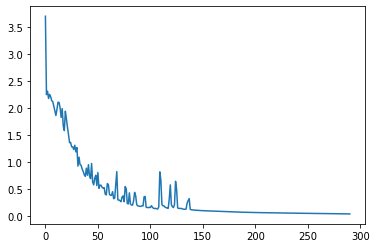

[[378   0   0   0   1   0   0   0   0   0]
 [  0 440   0   4   0   0   0   0   0   0]
 [  0   0 393   1   1   0   0   0   0   2]
 [  0   1   1 385   0   3   0   2   0   0]
 [  0   1   0   0 428   0   1   0   0   0]
 [  1   0   0   3   0 343   1   0   2   0]
 [  0   0   0   0   0   0 405   0   0   0]
 [  0   2   0   0   0   0   0 429   0   2]
 [  0   0   1   0   0   1   0   0 370   1]
 [  1   0   0   0   0   0   0   0   0 396]]
0.99175


<Figure size 432x288 with 0 Axes>

In [43]:
nn = NeuralNet(X_train, y_train_oh, [784, 80, 20], y_train_oh.shape[1], tanh, d_tanh, softmax, d_softmax, 
              cross_entropy, d_cross_entropy, random_state = 0, alpha = .1)

for i in range(300):
    nn.train(.0001, 10)
    
    if i % 10 == 0:
        clear_output()
        print('After ' + str(i * 10) + ' epochs')
        plt.plot(nn.losses)
        plt.show()
        plt.clf()
        print(confusion_matrix(y_train, np.argmax(nn.predict(X_train), axis = 1)))
        print(np.mean(np.argmax(nn.predict(X_train), axis = 1) == y_train))

[[ 896    0   21   10    2   17   21    2    7    4]
 [   0 1060   16   11    6   10   14    8   10    0]
 [  28    3  791   52   23   19   24   14   61   17]
 [   6    6   47  814    0   70    3   17   26   21]
 [   2    6   14    0  830    9   19    6   10   86]
 [  19   14   18  112   26  580   24    5   66   28]
 [  23    6   27    2   60   24  801    3   10    2]
 [   2   13   17   23    7    9    2  890    8   57]
 [  22    9   22   34   21   66   23    7  690   80]
 [   6    9    6    6   74   15    4   94   22  773]]


0.8125

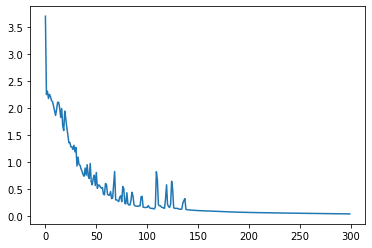

In [44]:
plt.plot(nn.losses)
print(confusion_matrix(y_test, np.argmax(nn.predict(X_test), axis = 1)))
np.mean(np.argmax(nn.predict(X_test), axis = 1) == y_test)

